In [ ]:
import pandas as pd
data = pd.read_csv('https://raw.githubusercontent.com/amankharwal/Website-data/master/ner_dataset.csv', encoding= 'unicode_escape')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [ ]:
from itertools import chain
def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}

    if token_or_tag == 'token':
        vocab = list(set(data['Word'].to_list()))
    else:
        vocab = list(set(data['Tag'].to_list()))

    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok


token2idx, idx2token = get_dict_map(data, 'token')
tag2idx, idx2tag = get_dict_map(data, 'tag')
data['Word_idx'] = data['Word'].map(token2idx)
data['Tag_idx'] = data['Tag'].map(tag2idx)

In [ ]:
data_fillna = data.fillna(method='ffill', axis=0)
# Groupby and collect columns
data_group = data_fillna.groupby(['Sentence #'],as_index=False)['Word', 'POS', 'Tag', 'Word_idx', 'Tag_idx'].agg(lambda x: list(x))

<ipython-input-3-2de26e3df461>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data_group = data_fillna.groupby(['Sentence #'],as_index=False)['Word', 'POS', 'Tag', 'Word_idx', 'Tag_idx'].agg(lambda x: list(x))


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
def get_pad_train_test_val(data_group, data):

    #get max token and tag length
    n_token = len(list(set(data['Word'].to_list())))
    n_tag = len(list(set(data['Tag'].to_list())))

    #Pad tokens (X var)
    tokens = data_group['Word_idx'].tolist()
    maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)

    #Pad Tags (y var) and convert it into one hot encoding
    tags = data_group['Tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]

    #Split train, test and validation set
    tokens_, test_tokens, tags_, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)
    train_tokens, val_tokens, train_tags, val_tags = train_test_split(tokens_,tags_,test_size = 0.25,train_size =0.75, random_state=2020)

    print(
        'train_tokens length:', len(train_tokens),
        '\ntrain_tokens length:', len(train_tokens),
        '\ntest_tokens length:', len(test_tokens),
        '\ntest_tags:', len(test_tags),
        '\nval_tokens:', len(val_tokens),
        '\nval_tags:', len(val_tags),
    )

    return train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags

train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags = get_pad_train_test_val(data_group, data)

train_tokens length: 32372 
train_tokens length: 32372 
test_tokens length: 4796 
test_tags: 4796 
val_tokens: 10791 
val_tags: 10791


In [ ]:
import numpy as np
import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model

from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

input_dim = len(list(set(data['Word'].to_list())))+1
output_dim = 64
input_length = max([len(s) for s in data_group['Word_idx'].tolist()])
n_tags = len(tag2idx)

In [ ]:
def get_bilstm_lstm_model():
    model = Sequential()

    # Add Embedding layer
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))

    # Add bidirectional LSTM
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))

    # Add LSTM
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

    # Add timeDistributed Layer
    model.add(TimeDistributed(Dense(n_tags, activation="relu")))

    #Optimiser
    # adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    return model

In [ ]:
def train_model(X, y, model):
    loss = list()
    for i in range(10):
        # fit model for one epoch on this sequence
        hist = model.fit(X, y, batch_size=1000, verbose=1, epochs=1, validation_split=0.2)
        loss.append(hist.history['loss'][0])
    return loss

results = pd.DataFrame()
model_bilstm_lstm = get_bilstm_lstm_model()
plot_model(model_bilstm_lstm)
results['with_add_lstm'] = train_model(train_tokens, np.array(train_tags), model_bilstm_lstm)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 104, 64)           2251456   
                                                                 
 bidirectional (Bidirectiona  (None, 104, 128)         66048     
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 104, 64)           49408     
                                                                 
 time_distributed (TimeDistr  (None, 104, 17)          1105      
 ibuted)                                                         
                                                                 
Total params: 2,368,017
Trainable params: 2,368,017
Non-trainable params: 0
_________________________________________________________________
26/26 [==============================] - 155s 

In [ ]:
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')
text = nlp(input("Enter Your Text: "))
displacy.render(text, style = 'ent', jupyter=True)

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, recall_score, classification_report
# ... (previous code)

# Convert the predicted tags back to indices
def decode_tags(predictions):
    decoded_tags = []
    for sequence in predictions:
        decoded_sequence = [idx2tag[np.argmax(tag)] for tag in sequence]
        decoded_tags.append(decoded_sequence)
    return decoded_tags

# Predict on the validation data
val_pred = model_bilstm_lstm.predict(val_tokens)
val_pred = decode_tags(val_pred)
val_true = decode_tags(val_tags)

# Flatten the lists for calculating metrics
val_pred_flat = [tag for sequence in val_pred for tag in sequence]
val_true_flat = [tag for sequence in val_true for tag in sequence]

# ... (continue with the rest of the code)

# Convert one-hot encoded tags back to tag indices
def decode_tags(tags_onehot):
    return np.argmax(tags_onehot, axis=-1)

# Predict using the trained model
def predict_labels(model, tokens):
    predicted_tags_onehot = model.predict(tokens)
    predicted_tags_indices = decode_tags(predicted_tags_onehot)
    return predicted_tags_indices

# Convert tag indices to tag labels
def convert_indices_to_labels(indices, idx2tag):
    return [idx2tag[idx] for idx in indices]
from sklearn.preprocessing import LabelEncoder

# Convert tag labels to indices using LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(list(tag2idx.keys()))

# Convert true labels to encoded indices
val_true_encoded = label_encoder.transform(val_true_flat)

# Convert predicted labels to encoded indices
val_pred_encoded = label_encoder.transform(val_pred_flat)

# Get the unique labels that are present in the ground truth
unique_labels = np.unique(val_true_encoded)

# Confusion Matrix
confusion = confusion_matrix(val_true_encoded, val_pred_encoded, labels=unique_labels)

# Continue with the rest of the evaluation metrics calculations as before

# Accuracy
accuracy = accuracy_score(val_true_flat, val_pred_flat)

# Precision
precision_micro = precision_score(val_true_flat, val_pred_flat, average='micro')
precision_macro = precision_score(val_true_flat, val_pred_flat, average='macro')

# Recall
recall_micro = recall_score(val_true_flat, val_pred_flat, average='micro')
recall_macro = recall_score(val_true_flat, val_pred_flat, average='macro')

# F1 Score
f1_micro = f1_score(val_true_flat, val_pred_flat, average='micro')
f1_macro = f1_score(val_true_flat, val_pred_flat, average='macro')

# Classification Report
class_report = classification_report(val_true_flat, val_pred_flat, target_names=list(tag2idx.keys()))

import matplotlib.pyplot as plt
import seaborn as sns

# ... (previous code)

# Confusion Matrix
confusion = confusion_matrix(val_true_encoded, val_pred_encoded, labels=unique_labels)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ... (rest of the code)

# Print metrics
print("Confusion Matrix:\n", confusion)
print("Accuracy:", accuracy)
print("Micro Precision:", precision_micro)
print("Macro Precision:", precision_macro)
print("Micro Recall:", recall_micro)
print("Macro Recall:", recall_macro)
print("Micro F1 Score:", f1_micro)
print("Macro F1 Score:", f1_macro)
print("Classification Report:\n", class_report)



Confusion Matrix:
 [[      0       0       0       0       0       0       0       0       0
        0       0       0       0       0       0       0      92]
 [      0       0       0       0       0       0       0       0       0
        0       0       0       0       0       0       0      71]
 [      0       0       3       0       0       0       0       0       0
        0       0       0       0       0       0       0    8613]
 [      0       0       0       0       0       0       2       0       0
        0       0       0       0       0       0       0    3551]
 [      0       0       0       0       0       0       0       0       0
        0       0       0       0       0       0       0      48]
 [      0       0       0       0       0       0       3       0       0
        0       0       0       0       0       0       0    4533]
 [      0       0       0       0       0       0      88       0       0
        0       0       0       0       0       1       0    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


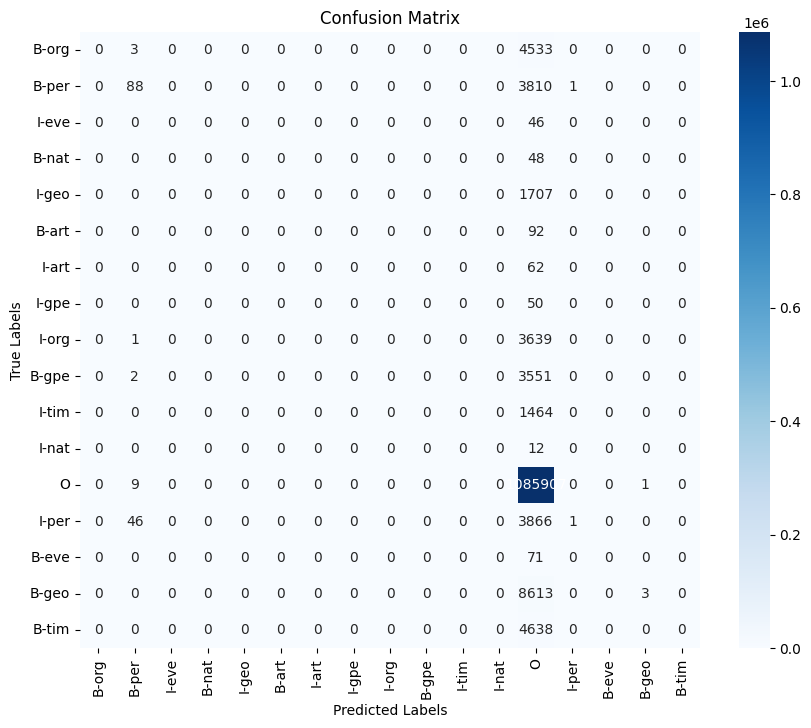

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


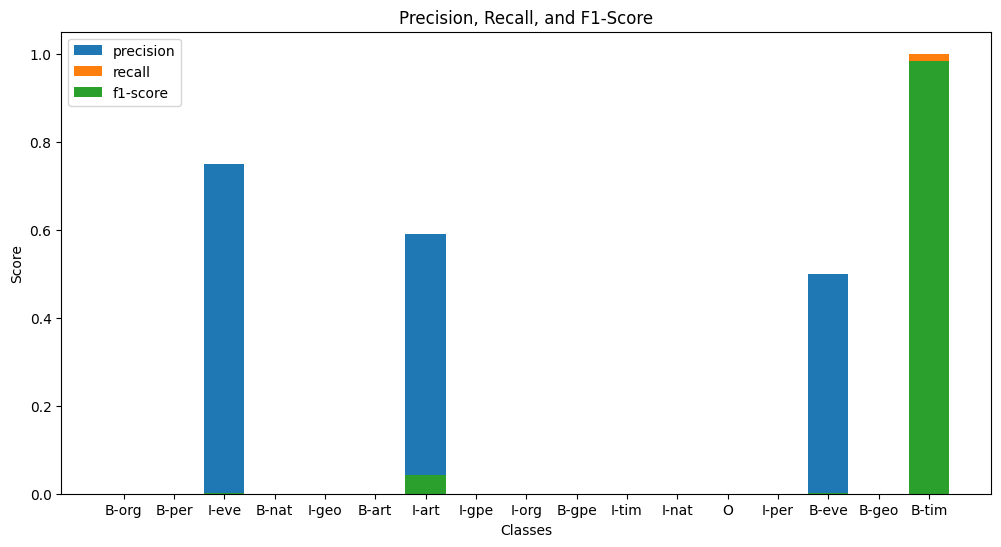

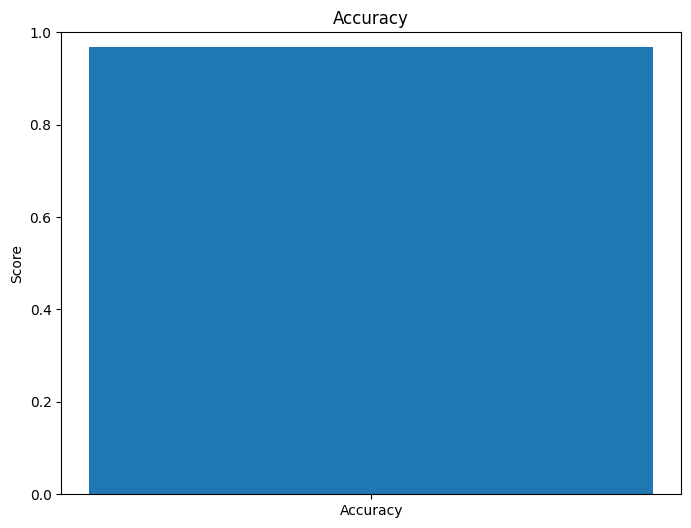

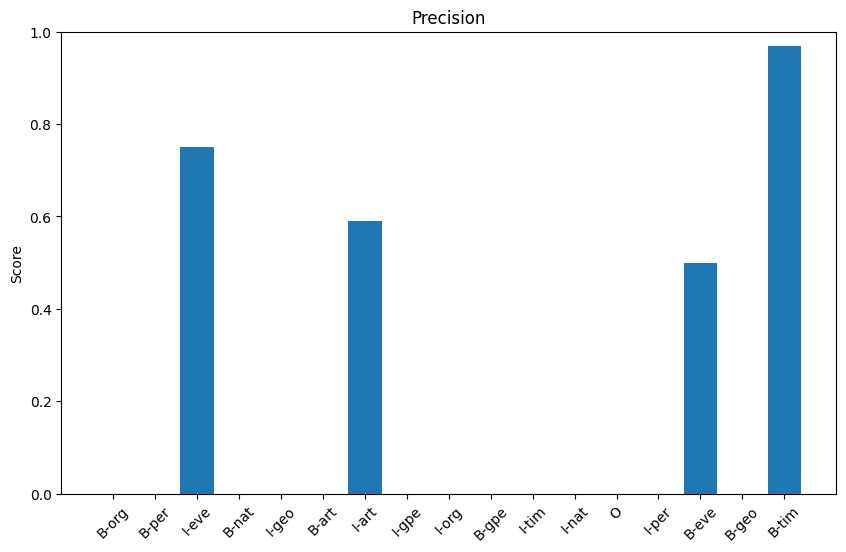

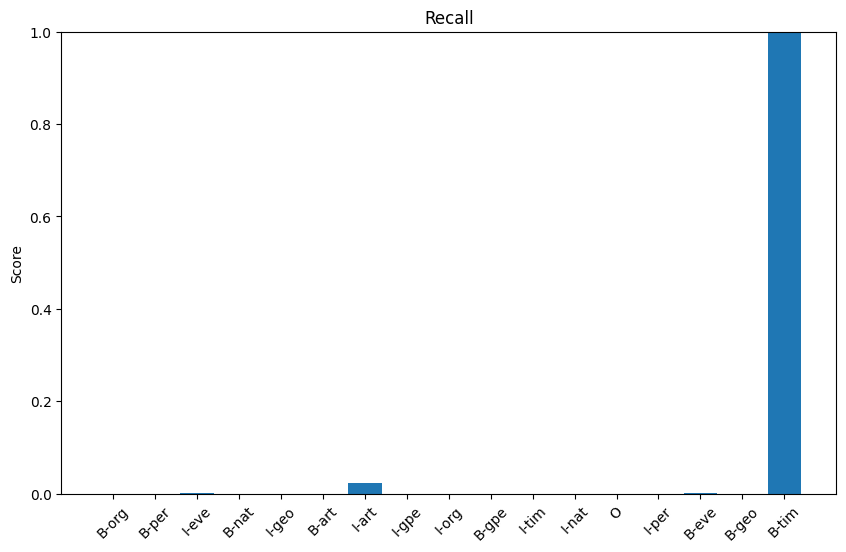

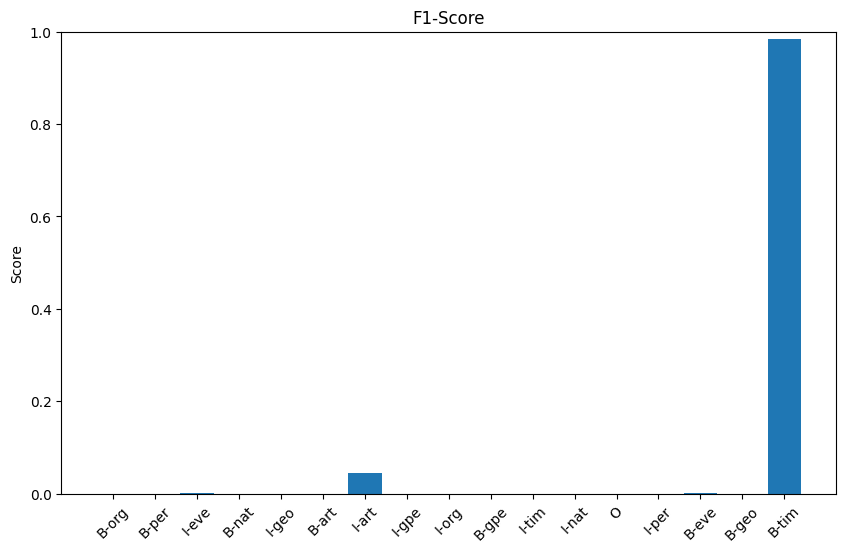

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Load the data and preprocess as in your initial code
# ...

# Define the get_dict_map function and other necessary preprocessing steps
# ...

# Define the get_pad_train_test_val function and other necessary preprocessing steps
# ...

# Define the get_bilstm_lstm_model function as in your initial code
# ...

# Train the model using the provided train_model function
# ...

# Convert the predicted tags back to indices
def decode_tags(predictions):
    decoded_tags = []
    for sequence in predictions:
        decoded_sequence = [idx2tag[np.argmax(tag)] for tag in sequence]
        decoded_tags.append(decoded_sequence)
    return decoded_tags

# Predict on the validation data
val_pred = model_bilstm_lstm.predict(val_tokens)
val_pred = decode_tags(val_pred)
val_true = decode_tags(val_tags)

# Flatten the lists for calculating metrics
val_pred_flat = [tag for sequence in val_pred for tag in sequence]
val_true_flat = [tag for sequence in val_true for tag in sequence]

# Calculate confusion matrix
conf_matrix = confusion_matrix(val_true_flat, val_pred_flat, labels=list(tag2idx.keys()))

# Calculate overall accuracy
accuracy = np.sum(np.diagonal(conf_matrix)) / np.sum(conf_matrix)

# Calculate classification report
class_report = classification_report(val_true_flat, val_pred_flat, target_names=list(tag2idx.keys()))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=list(tag2idx.keys()), yticklabels=list(tag2idx.keys()))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Plot precision, recall, and F1-score
report_data = classification_report(val_true_flat, val_pred_flat, target_names=list(tag2idx.keys()), output_dict=True)
classes = list(tag2idx.keys())
metrics = ['precision', 'recall', 'f1-score']

plt.figure(figsize=(12, 6))
for metric in metrics:
    scores = [report_data[label][metric] for label in classes]
    plt.bar(classes, scores, label=metric)
plt.xlabel("Classes")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1-Score")
plt.legend()
plt.show()

# ... (previous code)

# Plot accuracy
plt.figure(figsize=(8, 6))
plt.bar("Accuracy", accuracy)
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Accuracy")
plt.show()

# Plot precision
plt.figure(figsize=(10, 6))
precision_scores = [report_data[label]['precision'] for label in classes]
plt.bar(classes, precision_scores)
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Precision")
plt.show()

# Plot recall
plt.figure(figsize=(10, 6))
recall_scores = [report_data[label]['recall'] for label in classes]
plt.bar(classes, recall_scores)
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Recall")
plt.show()

# Plot F1-score
plt.figure(figsize=(10, 6))
f1_scores = [report_data[label]['f1-score'] for label in classes]
plt.bar(classes, f1_scores)
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("F1-Score")
plt.show()


In [ ]:
# ... (previous code)

# Plot line graph for accuracy
plt.figure(figsize=(12, 8))
plt.plot(classes, accuracy_scores * len(classes), label='Accuracy', marker='o')
plt.xlabel("Classes")
plt.ylabel("Accuracy Score")
plt.title("Accuracy by Class")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()

# Plot line graph for precision
plt.figure(figsize=(12, 8))
plt.plot(classes, precision_scores, label='Precision', marker='o')
plt.xlabel("Classes")
plt.ylabel("Precision Score")
plt.title("Precision by Class")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()

# Plot line graph for recall
plt.figure(figsize=(12, 8))
plt.plot(classes, recall_scores, label='Recall', marker='o')
plt.xlabel("Classes")
plt.ylabel("Recall Score")
plt.title("Recall by Class")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()

# Plot line graph for F1-score
plt.figure(figsize=(12, 8))
plt.plot(classes, f1_scores, label='F1-Score', marker='o')
plt.xlabel("Classes")
plt.ylabel("F1-Score")
plt.title("F1-Score by Class")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
Steve Jobs (stylized as Steve Jobs|) is a 2015 biographical drama film directed by Danny Boyle and written by Aaron Sorkin. A British-American co-production, it was adapted from the 2011 biography by Walter Isaacson and interviews conducted by Sorkin. The film covers 14 years (1984–1998) in the life of Apple Inc. co-founder Steve Jobs, specifically ahead of three press conferences he gave during that time. Jobs is portrayed by Michael Fassbender, with Kate Winslet as Joanna Hoffman and Seth Rogen, Katherine Waterston, Michael Stuhlbarg, and Jeff Daniels in supporting roles.

Development began in 2011 after the rights to Isaacson's book were acquired. Filming began in January 2015. A variety of actors were considered and cast before Fassbender eventually took the role. Editing was extensive on the project, with editor Elliot Graham starting while the film was still shooting. Daniel Pemberton served as composer, with a focus on dividing the score into three distinguishable sections.

In [ ]:
'Hi, My name is Aman Kharwal \n I am from India \n I want to work with Google \n Steve Jobs is My Inspiration'